In [ ]:
!pip install nltk
!pip install plotly
!pip install openml
!pip install seaborn
!pip install datasets
!pip install flaml[automl]
!pip install huggingface_hub
!pip install optimum[exporters]
!pip install install hummingbird_ml[extra]
!pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12

In [1]:
import cudf
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset
from flaml import AutoML
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [4]:
%matplotlib inline
# %load_ext cudf.pandas
%config IPCompleter.greedy=True

In [ ]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

In [10]:
def alpha(tokens):
    def transform_token(token):
        match token:
            case "n't":
                return "not"
            case "won't":
                return "wont"
            case _ if token.isalpha():
                return token
            case _:
                return None

    return list(filter(None, map(transform_token, tokens)))


def remove_stop_words(tokens):
    def is_not_stopword(token):
        to_remove = stopwords.words("english")
        return token not in to_remove

    return list(filter(is_not_stopword, tokens))


def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    return " ".join(map(lemmatizer.lemmatize, tokens))

In [6]:
df = pd.DataFrame(
    load_dataset("alexandreteles/image-generation-intent")["train"]
).dropna()

In [11]:
x = df["sentence"].str.lower().apply(word_tokenize).apply(alpha).apply(remove_stop_words).apply(lemmatize)
y = df["image_intent"]

In [28]:
x_train, x_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.3, random_state=42, stratify=y
)
x_test, x_val, y_test, y_val = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

vectorizer = TfidfVectorizer(strip_accents="ascii")

x_train = vectorizer.fit_transform(x_train).toarray()
x_test = vectorizer.transform(x_test).toarray()
x_val = vectorizer.transform(x_val).toarray()

In [13]:
# model = MultinomialNB().fit(x_train, y_train)

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10).fit(x_train, y_train)

Test Set Evaluation:

Accuracy: 0.9294268214644849

ROC AUC Score: 0.9293317753572312

Confusion Matrix: 
[[5189  350]
 [ 422 4978]]

Classification report: 
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93      5539
         1.0       0.93      0.92      0.93      5400

    accuracy                           0.93     10939
   macro avg       0.93      0.93      0.93     10939
weighted avg       0.93      0.93      0.93     10939




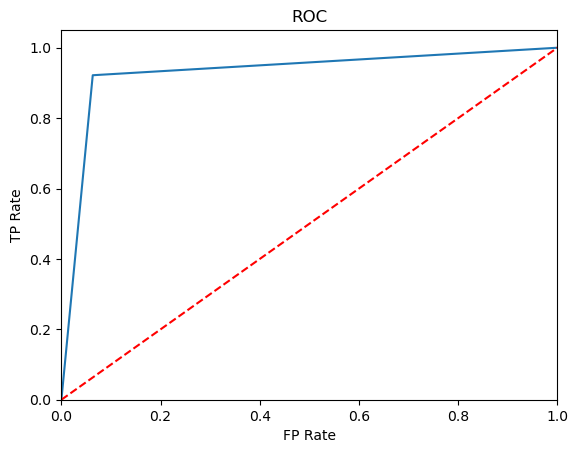

Validation Set Evaluation:

Accuracy: 0.9210165463022214

ROC AUC Score: 0.9209062004774227

Confusion Matrix: 
[[5149  390]
 [ 474 4926]]

Classification report: 
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92      5539
         1.0       0.93      0.91      0.92      5400

    accuracy                           0.92     10939
   macro avg       0.92      0.92      0.92     10939
weighted avg       0.92      0.92      0.92     10939




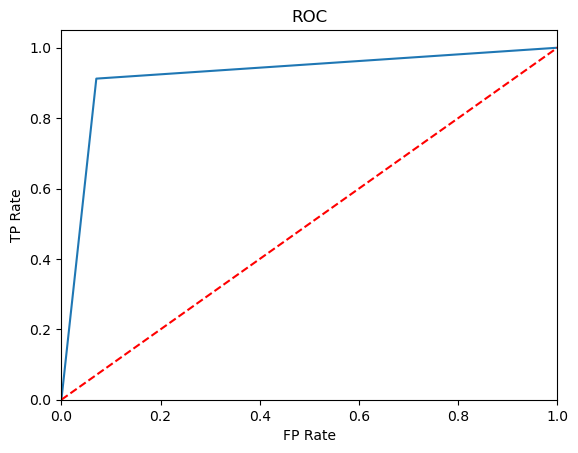

In [14]:
y_pred_test = clf.predict(x_test)
y_pred_val = clf.predict(x_val)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_pred_val)

print("Test Set Evaluation:\n")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test)}\n")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_test)}\n")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred_test)}\n")
print(f"Classification report: \n{classification_report(y_test, y_pred_test)}\n")

plt.plot(fpr_test, tpr_test)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.title("ROC")
plt.show()

print("Validation Set Evaluation:\n")
print(f"Accuracy: {accuracy_score(y_val, y_pred_val)}\n")
print(f"ROC AUC Score: {roc_auc_score(y_val, y_pred_val)}\n")
print(f"Confusion Matrix: \n{confusion_matrix(y_val, y_pred_val)}\n")
print(f"Classification report: \n{classification_report(y_val, y_pred_val)}\n")

plt.plot(fpr_val, tpr_val)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.title("ROC")
plt.show()

In [167]:
# %%timeit -r 3

text = vectorizer.transform(["How are you?"]).toarray()

prediction = clf.predict(text)

print(prediction)

[0.]


In [ ]:
from flaml import AutoML
automl = AutoML()

settings = {
    "time_budget": 1200,
    "metric": 'roc_auc',
    "task": 'classification',
    "log_file_name": 'image_intent.log',
    "early_stop": True
}

automl.fit(X_train=x_train, y_train=y_train, **settings)

In [35]:
automl.model.estimator

LGBMClassifier(colsample_bytree=0.49992209956020583,
               learning_rate=0.03747093469200654, max_bin=127,
               min_child_samples=2, n_estimators=1, n_jobs=-1, num_leaves=97,
               reg_alpha=0.02046640007359354, reg_lambda=0.006250841267358658,
               verbose=-1)

In [36]:
y_pred = automl.predict(x_test)
print('Predicted labels', y_pred)
print('True labels', y_test)
y_pred_proba = automl.predict_proba(x_test)[:,1]

Predicted labels [0. 1. 1. ... 0. 1. 0.]
True labels 13797    0.0
31883    1.0
53897    1.0
26308    1.0
49162    0.0
        ... 
35402    1.0
59306    1.0
5211     0.0
59148    1.0
65433    0.0
Name: image_intent, Length: 10939, dtype: float64


In [37]:
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

In [38]:
print(automl.model.estimator)

LGBMClassifier(colsample_bytree=0.49992209956020583,
               learning_rate=0.03747093469200654, max_bin=127,
               min_child_samples=2, n_estimators=1, n_jobs=-1, num_leaves=97,
               reg_alpha=0.02046640007359354, reg_lambda=0.006250841267358658,
               verbose=-1)


In [39]:
from hummingbird.ml import convert, load

In [54]:
onnx_model = convert(automl.model.estimator, 'onnx', x_val)
torch_model = convert(automl.model.estimator, 'pytorch')

In [55]:
%%timeit 3

onnx_model.predict(vectorizer.transform(["Can you show me a picture of yourself?"]).toarray())

4.43 ms ± 63.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [70]:
%%timeit 3

torch_model.predict(vectorizer.transform(["Can you show me a picture of yourself?"]).toarray())

5.63 ms ± 187 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [66]:
import onnx

onnx.save(onnx_model.model, "./intent.onnx")

In [68]:
import torch

torch.save(torch_model, "./intent.pkl")

In [69]:
print(torch_model)